In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# --- Preprocessing & Modeling ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# --- Experiment Tracking & Tuning ---
import mlflow
import optuna
from sklearn.metrics import f1_score

# --- Model Explainability ---
import shap

# --- Setup ---
# This allows us to import our own data_loader script from the 'src' folder
sys.path.append('..')
from src.data_loader import load_telco_data

# Set a visual style for plots
sns.set_theme(style="whitegrid")

# --- Load the Data ---
print("Loading data...")
df = load_telco_data()
print("Data loaded successfully.")

# --- Display Initial Info ---
print("\n--- First 5 Rows of Data ---")
display(df.head())

print("\n--- Data Summary & Types ---")
df.info()


Loading data...
Data loaded successfully.

--- First 5 Rows of Data ---


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



--- Data Summary & Types ---
<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling 

Starting Exploratory Data Analysis...
Plotting Churn by Contract Type...


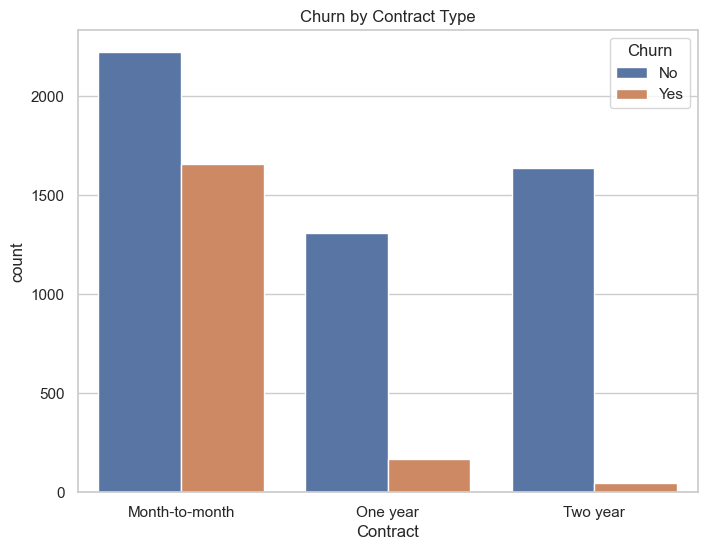


Plotting Churn by Customer Tenure...


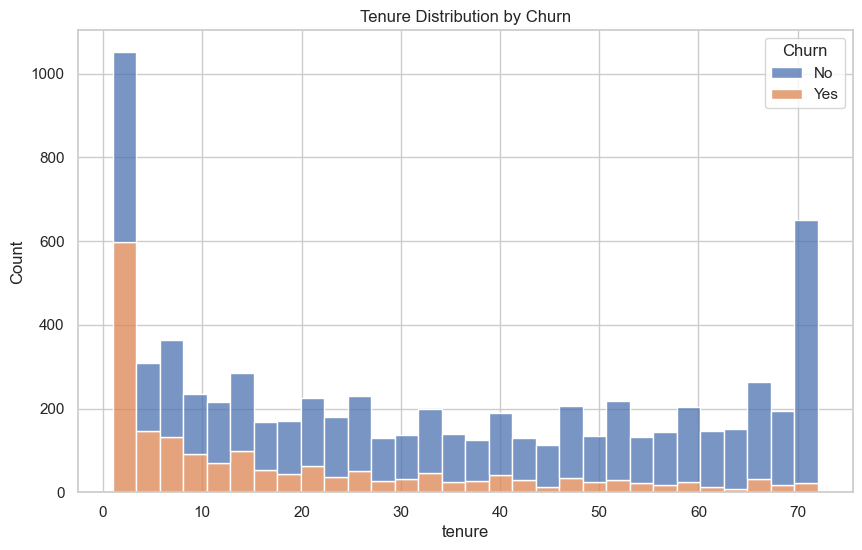


EDA complete.


In [10]:
# --- Exploratory Data Analysis (EDA) ---
print("Starting Exploratory Data Analysis...")

# Plot 1: Churn by Contract Type
# This helps us see if the contract length affects whether a customer leaves.
print("Plotting Churn by Contract Type...")
plt.figure(figsize=(8, 6))
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Churn by Contract Type')
plt.show()

# Plot 2: Churn by Tenure
# This shows if new or old customers are more likely to leave.
print("\nPlotting Churn by Customer Tenure...")
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='tenure', hue='Churn', multiple='stack', bins=30)
plt.title('Tenure Distribution by Churn')
plt.show()

print("\nEDA complete.")

In [11]:
# --- Data Preprocessing ---
print("Starting data preprocessing...")

# Drop customerID as it is just an identifier and not useful for prediction.
df_processed = df.drop('customerID', axis=1)

# Convert all categorical columns (text) into numerical columns (0s and 1s).
# This is a crucial step for the model to understand the data.
# drop_first=True helps to avoid redundant columns.
df_processed = pd.get_dummies(df_processed, drop_first=True)

# After get_dummies, the 'Churn' column is renamed to 'Churn_Yes'.
# We will rename it back to 'Churn' for clarity.
df_processed.rename(columns={'Churn_Yes': 'Churn'}, inplace=True)

print("Data has been transformed with one-hot encoding.")
print("\n--- First 5 Rows of Processed Data ---")
display(df_processed.head())


Starting data preprocessing...
Data has been transformed with one-hot encoding.

--- First 5 Rows of Processed Data ---


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,0,1,29.85,29.85,False,True,False,False,True,False,...,False,False,False,False,False,True,False,True,False,False
1,0,34,56.95,1889.50,True,False,False,True,False,False,...,False,False,False,True,False,False,False,False,True,False
2,0,2,53.85,108.15,True,False,False,True,False,False,...,False,False,False,False,False,True,False,False,True,True
3,0,45,42.30,1840.75,True,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,False
4,0,2,70.70,151.65,False,False,False,True,False,False,...,False,False,False,False,False,True,False,True,False,True


In [12]:
# --- Train-Test Split & Feature Scaling ---
print("Splitting data into training and testing sets...")

# 1. Separate our data into features (X) and the target (y)
# X contains all the columns we will use for prediction.
# y is the single column we are trying to predict (Churn).
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']

# 2. Split the data
# We'll use 80% of the data for training and 20% for testing.
# random_state=42 ensures we get the same split every time we run this code.
# stratify=y ensures the proportion of churners is the same in both train and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Data split successfully.")

# 3. Scale the features
# Models work better when all features are on a similar scale.
# We 'fit' the scaler only on the training data to avoid data leakage from the test set.
print("\nScaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features scaled successfully.")

# --- Verify the shapes of our new datasets ---
print("\n--- Dataset Shapes ---")
print(f"X_train_scaled: {X_train_scaled.shape}")
print(f"X_test_scaled:  {X_test_scaled.shape}")
print(f"y_train:        {y_train.shape}")
print(f"y_test:         {y_test.shape}")


Splitting data into training and testing sets...
Data split successfully.

Scaling features...
Features scaled successfully.

--- Dataset Shapes ---
X_train_scaled: (5625, 30)
X_test_scaled:  (1407, 30)
y_train:        (5625,)
y_test:         (1407,)


In [13]:
# --- Hyperparameter Tuning with Optuna & MLflow ---
print("Starting hyperparameter tuning with Optuna...")

# Set an experiment name for MLflow so all our runs are grouped together.
mlflow.set_experiment("Churn_Prediction")

# 1. Define the 'objective' function that Optuna will try to optimize.
# For each 'trial', it will train a model with a new set of parameters.
def objective(trial):
    # This 'with' block tells MLflow to log the following as one experiment run
    with mlflow.start_run(nested=True):
        # Define the search space for hyperparameters.
        # Optuna will pick values from these ranges for each trial.
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'random_state': 42,
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0)
        }

        # Log the specific parameters MLflow is trying for this run
        mlflow.log_params(params)

        # Create and train the XGBoost model with the current trial's parameters
        model = xgb.XGBClassifier(**params, use_label_encoder=False)
        model.fit(X_train_scaled, y_train)

        # Evaluate the model's performance on the unseen test set
        preds = model.predict(X_test_scaled)
        f1 = f1_score(y_test, preds)

        # Log the resulting F1 score for this trial
        mlflow.log_metric('f1_score', f1)

    # Optuna's goal is to find the parameters that return the highest F1 score
    return f1

# 2. Create a 'study' object. We tell it we want to 'maximize' the F1 score.
study = optuna.create_study(direction='maximize')

# 3. Start the optimization process. This will run the 'objective' function 20 times.
study.optimize(objective, n_trials=20)

# --- Print the final results of the tuning process ---
print("\nHyperparameter tuning finished!")
print(f"Best trial's F1 score: {study.best_value}")
print("Best trial's parameters:")
print(study.best_params)


[I 2025-07-21 21:47:36,169] A new study created in memory with name: no-name-8f0f9390-fd6d-4228-a382-ca50f7c905ab


Starting hyperparameter tuning with Optuna...


C:\Users\soubh\OneDrive\Desktop\churn-project\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:47:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-07-21 21:47:38,578] Trial 0 finished with value: 0.5521126760563381 and parameters: {'n_estimators': 127, 'learning_rate': 0.15541227001247673, 'max_depth': 9, 'subsample': 0.9056829232569721, 'colsample_bytree': 0.737392210768652}. Best is trial 0 with value: 0.5521126760563381.
C:\Users\soubh\OneDrive\Desktop\churn-project\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:47:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-07-21 21:47:39,118] Trial 1 finished with value: 0.5512465373961218 and parameters: {'n_estimators': 407, 'learning_rate': 0.207996455966


Hyperparameter tuning finished!
Best trial's F1 score: 0.5805515239477503
Best trial's parameters:
{'n_estimators': 670, 'learning_rate': 0.01637497092869597, 'max_depth': 3, 'subsample': 0.7260016443038656, 'colsample_bytree': 0.7814171764983147}


Training the final model with the best parameters found by Optuna...

Using best parameters:
{'n_estimators': 670, 'learning_rate': 0.01637497092869597, 'max_depth': 3, 'subsample': 0.7260016443038656, 'colsample_bytree': 0.7814171764983147}


C:\Users\soubh\OneDrive\Desktop\churn-project\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:48:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Final model trained successfully.

Calculating SHAP values to explain the model...


 99%|===================| 1395/1407 [00:22<00:00]        

SHAP values calculated.

--- Generating SHAP Plots ---
Displaying overall feature importance...


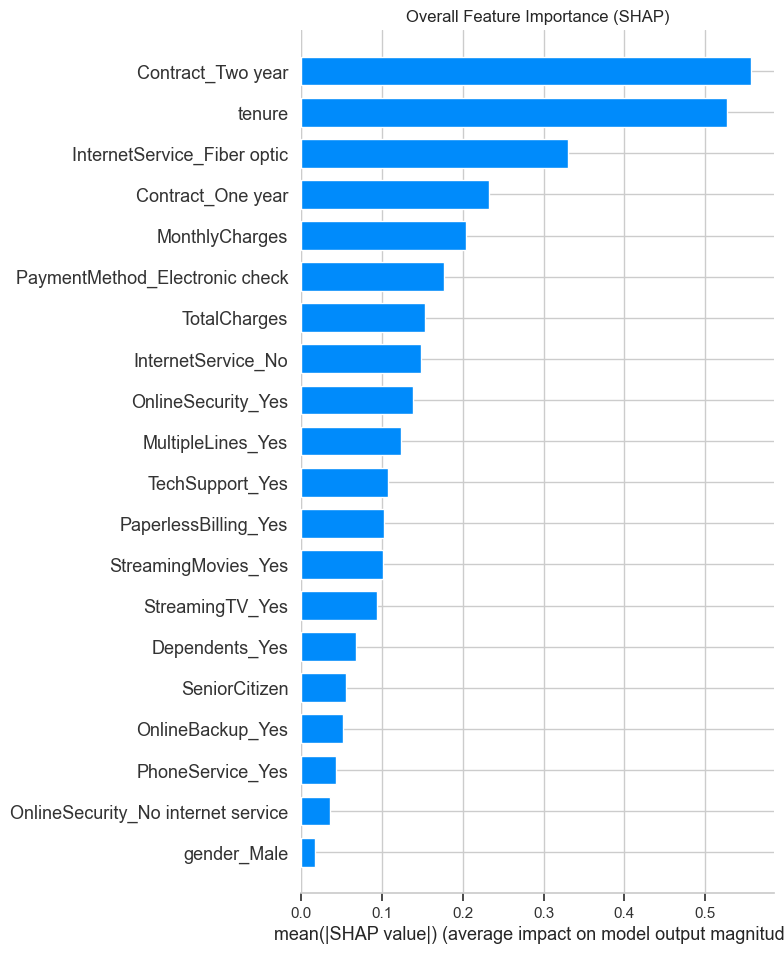


Displaying detailed feature impact...


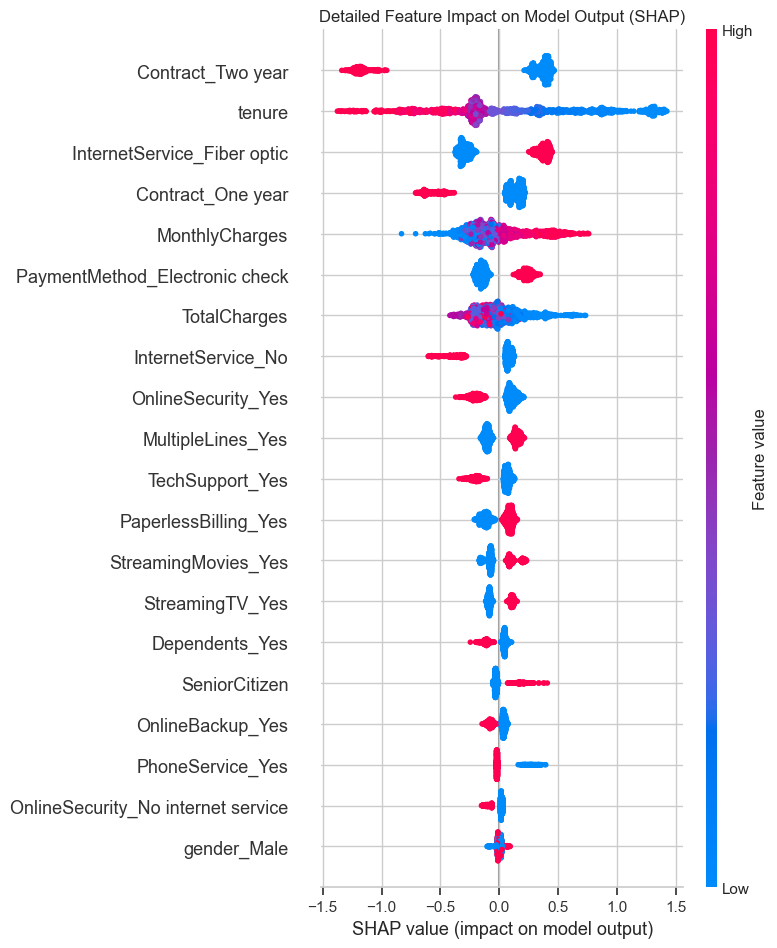

In [14]:
# --- Final Model Training & SHAP Explainability ---
print("Training the final model with the best parameters found by Optuna...")

# 1. Get the best hyperparameters from the Optuna study.
# The 'study' variable was created and populated in the previous cell.
best_params = study.best_params
print("\nUsing best parameters:")
print(best_params)

# 2. Train the final, best model with these parameters.
final_model = xgb.XGBClassifier(**best_params, use_label_encoder=False, random_state=42)
final_model.fit(X_train_scaled, y_train)
print("\nFinal model trained successfully.")

# 3. Create a SHAP explainer to understand the model's logic.
# We use the scaled training data to create the explainer.
print("\nCalculating SHAP values to explain the model...")
explainer = shap.Explainer(final_model, X_train_scaled)

# We calculate SHAP values for the test set to see how the model made its predictions.
shap_values = explainer(X_test_scaled)
print("SHAP values calculated.")

# 4. Generate SHAP summary plots to visualize the results.
print("\n--- Generating SHAP Plots ---")

# Plot 1: Overall Feature Importance (Bar Plot)
# This plot shows which features have the biggest average impact on predictions.
print("Displaying overall feature importance...")
plt.figure()
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("Overall Feature Importance (SHAP)")
plt.show()

# Plot 2: Detailed Feature Impact (Beeswarm Plot)
# This is the most insightful plot. It shows HOW each feature's value impacts the prediction.
# - Each dot is a customer in the test set.
# - Red dots = high feature value, Blue dots = low feature value.
# - X-axis: A positive SHAP value means the feature pushed the prediction towards "Churn".
print("\nDisplaying detailed feature impact...")
plt.figure()
shap.summary_plot(shap_values, X_test, show=False)
plt.title("Detailed Feature Impact on Model Output (SHAP)")
plt.show()


In [15]:
import pickle

# Save the final trained model
with open('final_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

# Save the scaler object
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Model and scaler saved successfully!")

Model and scaler saved successfully!


In [16]:
import json

# Get the column names from the training data (before scaling)
model_columns = list(X.columns)

# Save the list of columns to a file
with open('model_columns.json', 'w') as f:
    json.dump(model_columns, f)

print("Model columns saved successfully!")

Model columns saved successfully!
